In [1]:
from tensorflow.keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_protein_logo, plot_protein_importance_scores

from ppi_utils import load_ppi_data, load_ppi_predictor, animate_ppi_example


Using TensorFlow backend.
2021-12-09 06:46:41.470694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2021-12-09 06:46:43.887155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 06:46:43.889097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-09 06:46:43.932511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 06:46:43.933539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.3

In [2]:
#Load PPI data and predictor

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = OneHotEncoder(seq_length, residue_map)

train_data_path = 'coiled_coil_binders_big_set_train.csv'
test_data_path = 'coiled_coil_binders_big_set_test.csv'

x_1_train, x_2_train, l_1_train, l_2_train, y_train, x_1_test, x_2_test, l_1_test, l_2_test, y_test = load_ppi_data(train_data_path, test_data_path, encoder)



Training set size = 40000
Test set size = 4000
x_1_train.shape = (40000, 1, 81, 20)
x_2_train.shape = (40000, 1, 81, 20)
l_1_train.shape = (40000, 1)
l_2_train.shape = (40000, 1)
y_train.shape = (40000, 1)
x_1_test.shape = (4000, 1, 81, 20)
x_2_test.shape = (4000, 1, 81, 20)
l_1_test.shape = (4000, 1)
l_2_test.shape = (4000, 1)
y_test.shape = (4000, 1)


In [3]:
predictor_path = 'saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.hdf5'

predictor = load_ppi_predictor(predictor_path)


2021-12-09 06:47:00.950012: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-09 06:47:00.976355: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


In [4]:
#Define sequence template and background

#Define sequence templates

sequence_templates = [
    '$' * i + '#' * (seq_length - i)
    for i in range(seq_length+1)
]

onehot_templates = [encoder(sequence_template)[None, ...] for sequence_template in sequence_templates]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]

#Calculate background distributions

pseudo_count = 0.1

x_means = []
for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_mean_len = (np.sum(x_train_len, axis=(0, 1)) + pseudo_count) / (np.sum(x_train_len, axis=(0, 1, 3)).reshape(-1, 1) + 20. * pseudo_count)
        x_means.append(x_mean_len)
    else :
        x_means.append(np.ones((x_1_train.shape[2], x_1_train.shape[3])))


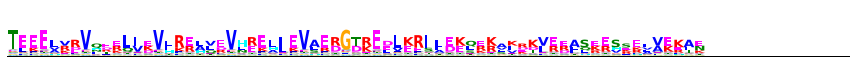

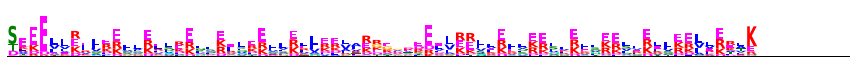

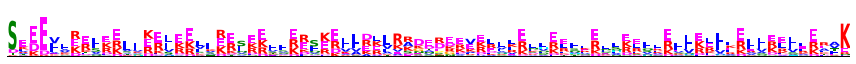

In [5]:
#Visualize a few background sequence distributions

visualize_len = 67

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 72

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 81

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)


In [6]:
#Calculate mean training set kl-divergence against background

mean_kl_divs = []

for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_train_clipped_len = np.clip(np.copy(x_train_len[:, 0, :, :]), 1e-8, 1. - 1e-8)

        kl_divs = np.sum(x_train_clipped_len * np.log(x_train_clipped_len / np.tile(np.expand_dims(x_means[i], axis=0), (x_train_clipped_len.shape[0], 1, 1))), axis=-1) / np.log(2.0)

        x_mean_kl_divs = np.sum(kl_divs * sequence_masks[i], axis=-1) / np.sum(sequence_masks[i])
        x_mean_kl_div = np.mean(x_mean_kl_divs)

        mean_kl_divs.append(x_mean_kl_div)
        
        print("[Length = " + str(i) + "] Mean KL Div against background (bits) = " + str(x_mean_kl_div))
    else :
        mean_kl_divs.append(0)


[Length = 67] Mean KL Div against background (bits) = 1.5100551162254858
[Length = 68] Mean KL Div against background (bits) = 2.5308799367061363
[Length = 69] Mean KL Div against background (bits) = 2.6996244284170974
[Length = 70] Mean KL Div against background (bits) = 2.6111063488578923
[Length = 71] Mean KL Div against background (bits) = 2.6478444593440154
[Length = 72] Mean KL Div against background (bits) = 2.686451614888409
[Length = 73] Mean KL Div against background (bits) = 2.6640224552062888
[Length = 74] Mean KL Div against background (bits) = 2.7293733130535136
[Length = 75] Mean KL Div against background (bits) = 2.61486080385328
[Length = 76] Mean KL Div against background (bits) = 2.667692958312886
[Length = 77] Mean KL Div against background (bits) = 2.673280307495861
[Length = 78] Mean KL Div against background (bits) = 2.641224258054648
[Length = 79] Mean KL Div against background (bits) = 2.63453398162075
[Length = 80] Mean KL Div against background (bits) = 2.673

In [7]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    n_inputs=2,
    multi_input_mode='siamese',
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=81,
    n_out_channels=20,
    input_templates=onehot_templates,
    input_backgrounds=x_means,
    batch_size=32,
    n_samples=32,
    sample_mode='gumbel',
    zeropad_input=True,
    mask_dropout=False,
    network_config=network_config
)


In [8]:
#Train scrambler

n_epochs = 10

train_history = scrambler.train(
    predictor,
    [x_1_train, x_2_train],
    y_train,
    [x_1_test, x_2_test],
    y_test,
    n_epochs,
    group_train=[l_1_train, l_2_train],
    group_test=[l_1_test, l_2_test],
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 1250 : 10},
    nll_mode='reconstruction',
    predictor_task='classification',
    entropy_mode='target',
    entropy_bits=0.5,
    entropy_weight=10.
)


/home/ubuntu/anaconda3/envs/python_3_8_tf2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-12-09 06:47:46.161652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-09 06:47:46.354804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Train on 40000 samples, validate on 4000 samples
Epoch 1/10
40000/40000 [==============================] - 164s 4ms/sample - loss: 0.6403 - nll_loss: 0.5207 - entropy_loss: 0.1196 - val_loss: 0.4769 - val_nll_loss: 0.3994 - val_entropy_loss: 0.0775
Epoch 2/10
40000/40000 [==============================] - 137s 3ms/sample - loss: 0.4483 - nll_loss: 0.3765 - entropy_loss: 0.0718 - val_loss: 0.3958 - val_nll_loss: 0.3242 - val_entropy_loss: 0.0716
Epoch 3/10
40000/40000 [==============================] - 137s 3ms/sample - loss: 0.3850 - nll_loss: 0.3274 - entropy_loss: 0.0576 - val_loss: 0.3509 - val_nll_loss: 0.3041 - val_entropy_loss: 0.0468
Epoch 4/10
40000/40000 [==============================] - 137s 3ms/sample - loss: 0.3481 - nll_loss: 0.3018 - entropy_loss: 0.0463 - val_loss: 0.3233 - val_nll_loss: 0.2861 - val_entropy_loss: 0.0372
Epoch 5/10
40000/40000 [==============================] - 140s 3ms/sample - loss: 0.3262 - nll_loss: 0.2862 - entropy_loss: 0.0400 - val_loss: 0.3045 -

In [9]:
#Save scrambler checkpoint
save_dir = 'saved_models'

model_name = 'ppi_inclusion_scrambler_bits_05_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

#Sub-select train history monitor (one example only) to save space
for t in range(len(train_history['monitor_pwms'])) :
    for k in range(len(train_history['monitor_pwms'][t])) :
        train_history['monitor_pwms'][t][k] = train_history['monitor_pwms'][t][k][0:1, ...]
        train_history['monitor_importance_scores'][t][k] = train_history['monitor_importance_scores'][t][k][0:1, ...]

    train_history['monitor_nll_losses'][t] = train_history['monitor_nll_losses'][t][0:1, ...]
    train_history['monitor_entropy_losses'][t] = train_history['monitor_entropy_losses'][t][0:1, ...]

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models/ppi_inclusion_scrambler_bits_05_epochs_10.h5 


In [10]:
#Load models
save_dir = 'saved_models'

model_name = 'ppi_inclusion_scrambler_bits_05_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models/ppi_inclusion_scrambler_bits_05_epochs_10.h5 


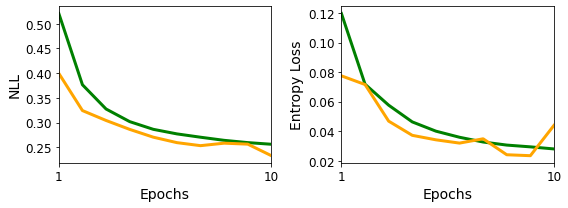

In [11]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [12]:
#Interpret the test set using the trained scrambler

[pwm_1_test, pwm_2_test], [sample_1_test, sample_2_test], [importance_scores_1_test, importance_scores_2_test] = scrambler.interpret([x_1_test, x_2_test], group=[l_1_test, l_2_test])


Test pair 0:


/home/ubuntu/anaconda3/envs/python_3_8_tf2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 - Prediction (original) = 0.85
 - Predictions (scrambled) = [0.78, 0.81, 0.18, 0.57, 0.58, 0.88, 0.35, 0.82, 0.77, 0.77, 0.83, 0.93, 0.73, 0.69, 0.91, 0.79, 0.86, 0.81, 0.54, 0.61, 0.84, 0.65, 0.78, 0.76, 0.79, 0.83, 0.57, 0.88, 0.66, 0.48, 0.84, 0.89]
Binder 1:


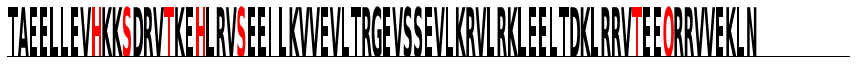

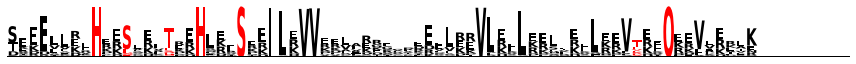

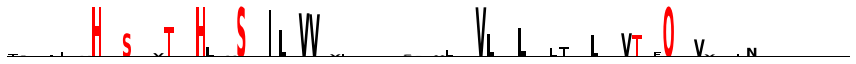

Binder 2:


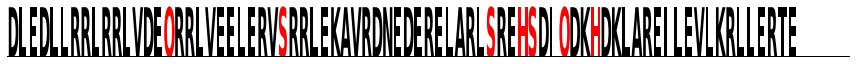

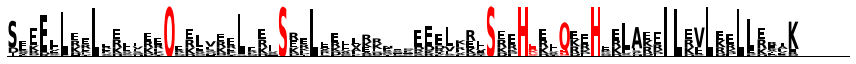

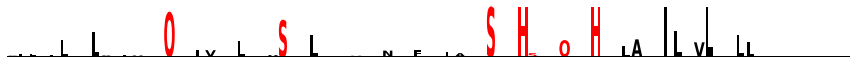

In [13]:
#Visualize a few reconstructed sequence patterns

#Color by ground truth hbnet positions for test pair 0
special_sequence_template_1 = ("TAEELLEV$KK$DRV$KE$LRV$EEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRV$EE$RRVVEKLN" + "#" * 81)[:81]
special_sequence_template_2 = ("DLEDLLRRLRRLVDE$RRLVEELERV$RRLEKAVRDNEDERELARL$RE$$DI$DK$DKLAREILEVLKRLLERTE" + "#" * 81)[:81]

score_quantile = 0.95

plot_examples = [0]
save_examples = []

for test_ix in plot_examples :
    
    pwm_1_curr = pwm_1_test[test_ix:test_ix+1, ...] * sequence_masks[l_1_test[test_ix, 0]][None, None, :, None]
    pwm_2_curr = pwm_2_test[test_ix:test_ix+1, ...] * sequence_masks[l_2_test[test_ix, 0]][None, None, :, None]
    
    importance_scores_1_curr = importance_scores_1_test[test_ix:test_ix+1, ...] * sequence_masks[l_1_test[test_ix, 0]][None, None, :, None]
    importance_scores_2_curr = importance_scores_2_test[test_ix:test_ix+1, ...] * sequence_masks[l_2_test[test_ix, 0]][None, None, :, None]
    
    print("Test pair " + str(test_ix) + ":")
    
    y_test_hat_ref = predictor.predict(x=[x_1_test[test_ix:test_ix+1, ...], x_2_test[test_ix:test_ix+1, ...]], batch_size=1)[0, 0]
    y_test_hat = predictor.predict(x=[sample_1_test[test_ix, ...], sample_2_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    sequence_template_1 = sequence_templates[l_1_test[test_ix, 0]]
    sequence_template_2 = sequence_templates[l_2_test[test_ix, 0]]
    if special_sequence_template_1 is not None :
        sequence_template_1 = special_sequence_template_1
        sequence_template_2 = special_sequence_template_2
    
    q_1 = np.quantile(importance_scores_1_curr[0, 0, :, :], q=score_quantile)
    q_2 = np.quantile(importance_scores_2_curr[0, 0, :, :], q=score_quantile)
    
    seq_1 = encoder.decode(x_1_test[test_ix, 0, :, :])[:l_1_test[test_ix, 0]]
    seq_2 = encoder.decode(x_2_test[test_ix, 0, :, :])[:l_2_test[test_ix, 0]]
    
    print("Binder 1:")

    plot_protein_logo(residue_map, x_1_test[test_ix, 0, :, :], sequence_template=sequence_template_1.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence_binder_1")
    plot_protein_logo(residue_map, pwm_1_curr[0, 0, :, :], sequence_template=sequence_template_1.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm_binder_1")
    plot_protein_importance_scores(importance_scores_1_curr[0, 0, :, :].T, seq_1, figsize=(12, 1), score_clip=q_1, sequence_template=sequence_template_1, single_color='red', fixed_sequence_template_scores=False, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores_binder_1")

    print("Binder 2:")

    plot_protein_logo(residue_map, x_2_test[test_ix, 0, :, :], sequence_template=sequence_template_2.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence_binder_2")
    plot_protein_logo(residue_map, pwm_2_curr[0, 0, :, :], sequence_template=sequence_template_2.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm_binder_2")
    plot_protein_importance_scores(importance_scores_2_curr[0, 0, :, :].T, seq_2, figsize=(12, 1), score_clip=q_2, sequence_template=sequence_template_2, single_color='red', fixed_sequence_template_scores=False, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores_binder_2")
